Source code -> https://github.com/home-assistant/home-assistant/blob/dev/homeassistant/components/london_air/sensor.py

API for hourly returns data in format (see `hourly.json`):
```
LocalAuthority (Borough)
    Site
        Species (CO2, NO2)
```

Not all Boroughs have sites, and generally each site might have a different combination of species. This makes it tedious to get the data into tabular format - we will require multiindex

In [1]:
from datetime import timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List, Set, Dict, Tuple, Optional

In [2]:
CONF_LOCATIONS = "locations"

ALL_AUTHORITIES = [
    'Barking and Dagenham',
     'Barnet',
     'Bexley',
     'Brent',
     'Bromley',
     'Camden',
     'City of London',
     'Croydon',
     'Ealing',
     'Enfield',
     'Greenwich',
     'Hackney',
     'Hammersmith and Fulham',
     'Haringey',
     'Harrow',
     'Havering',
     'Hillingdon',
     'Hounslow',
     'Islington',
     'Kensington and Chelsea',
     'Kingston',
     'Lambeth',
     'Lewisham',
     'Merton',
     'Newham',
     'Redbridge',
     'Richmond',
     'Southwark',
     'Sutton',
     'Tower Hamlets',
     'Waltham Forest',
     'Wandsworth',
     'Westminster'
]

## Use only authorities with data, this might change over time
AUTHORITIES = [
    "Barking and Dagenham",
    "Bexley",
    "Brent",
    "Camden",
    "City of London",
    "Croydon",
    "Ealing",
    "Enfield",
    "Greenwich",
    "Hackney",
    "Haringey",
    "Harrow",
    "Havering",
    "Hillingdon",
    "Islington",
    "Kensington and Chelsea",
    "Kingston",
    "Lambeth",
    "Lewisham",
    "Merton",
    "Redbridge",
    "Richmond",
    "Southwark",
    "Sutton",
    "Tower Hamlets",
    "Wandsworth",
    "Westminster",
]

LAQ_HOURLY_URL = "http://api.erg.kcl.ac.uk/AirQuality/Hourly/MonitoringIndex/GroupName=London/Json"

TIMEOUT = 10

In [3]:
len(AUTHORITIES)

27

Helper for making the request

In [4]:
def request_data(url : str, timeout : int = TIMEOUT) -> Dict:
    """
    Request data from a URL and return valid data as dictionary.
    """
    try:
        response = requests.get(url, timeout=TIMEOUT)
        if response.status_code == 200:
            return response.json()
        else:
            raise LondonAirQualityException(
                f"Status code {response.status_code} returned from {url}")

    except requests.exceptions.Timeout:
        raise LondonAirQualityException(
            f"Request timeout, current timeout is {timeout} seconds"
        )

    except requests.exceptions.ConnectionError as exc:
        raise LondonAirQualityException(f"Internet connection error: {exc}")

Most of the functionality of this package is parsing this raw data. 

In [5]:
def parse_species(species_data):
    """Iterate over list of species at each site."""
    parsed_species_data = []
    quality_list = []
    for species in species_data:
        if species["@AirQualityBand"] != "No data":
            species_dict = {}
            species_dict["description"] = species["@SpeciesDescription"]
            species_dict["code"] = species["@SpeciesCode"]
            species_dict["quality"] = species["@AirQualityBand"]
            species_dict["index"] = species["@AirQualityIndex"]
            species_dict["summary"] = (
                species_dict["code"] + " is " + species_dict["quality"]
            )
            parsed_species_data.append(species_dict)
            quality_list.append(species_dict["quality"])
    return parsed_species_data, quality_list


def parse_site(entry_sites_data):
    """Iterate over all sites at an local authority and tidy the data."""
    authority_data = []
    for site in entry_sites_data:
        site_data = {}
        species_data = []

        site_data["updated"] = site["@BulletinDate"]
        site_data["latitude"] = site["@Latitude"]
        site_data["longitude"] = site["@Longitude"]
        site_data["site_code"] = site["@SiteCode"]
        site_data["site_name"] = site["@SiteName"].split("-")[-1].lstrip()
        site_data["site_type"] = site["@SiteType"]

        if isinstance(site["Species"], dict):
            species_data = [site["Species"]]
        else:
            species_data = site["Species"]

        parsed_species_data, quality_list = parse_species(species_data)

        if not parsed_species_data:
            parsed_species_data.append("no_species_data")
        site_data["pollutants"] = parsed_species_data

        if quality_list:
            site_data["pollutants_status"] = max(
                set(quality_list), key=quality_list.count
            )
            site_data["number_of_pollutants"] = len(quality_list)
        else:
            site_data["pollutants_status"] = "no_species_data"
            site_data["number_of_pollutants"] = 0

        authority_data.append(site_data)
    return authority_data


def parse_hourly_response(hourly_response : Dict) -> Dict:
    """Return data indexed by Borough."""
    data = dict.fromkeys(AUTHORITIES)
    for authority in AUTHORITIES:
        try:
            for entry in hourly_response["HourlyAirQualityIndex"]["LocalAuthority"]:
                if entry["@LocalAuthorityName"] == authority:

                    if isinstance(entry["Site"], dict):
                        entry_sites_data = [entry["Site"]]
                    else:
                        entry_sites_data = entry["Site"]

                    data[authority] = parse_site(entry_sites_data)
        except Exception as exc: 
            # catch misformatted or missing data
            # print(exc)
            data[authority] = {}
    return data

class LondonAirQualityException(Exception):
    pass

In [6]:
try:
    hourly_data_raw = request_data(LAQ_HOURLY_URL)
except LondonAirQualityException as exc:
    print(exc)

In [7]:
# hourly_data_raw

The API response lists 33 `LocalAuthority` but only 27 contain actual data

In [8]:
len(hourly_data_raw['HourlyAirQualityIndex']['LocalAuthority'])

33

Show the raw data for a single site

In [9]:
hourly_data_raw['HourlyAirQualityIndex']['LocalAuthority'][0]

{'@LocalAuthorityCode': '1',
 '@LocalAuthorityName': 'Barking and Dagenham',
 '@LaCentreLatitude': '51.538435',
 '@LaCentreLongitude': '0.11467',
 '@LaCentreLatitudeWGS84': '6717095.01808',
 '@LaCentreLongitudeWGS84': '12765.0060093',
 'Site': [{'@BulletinDate': '2019-09-26 07:00:00',
   '@SiteCode': 'BG1',
   '@SiteName': 'Barking and Dagenham - Rush Green',
   '@SiteType': 'Suburban',
   '@Latitude': '51.563752',
   '@Longitude': '0.177891',
   '@LatitudeWGS84': '6721627.34498',
   '@LongitudeWGS84': '19802.7355367',
   '@OwnerID': '1',
   'Species': [{'@SpeciesCode': 'NO2',
     '@SpeciesDescription': 'Nitrogen Dioxide',
     '@AirQualityIndex': '1',
     '@AirQualityBand': 'Low',
     '@IndexSource': 'Measurement'},
    {'@SpeciesCode': 'SO2',
     '@SpeciesDescription': 'Sulphur Dioxide',
     '@AirQualityIndex': '1',
     '@AirQualityBand': 'Low',
     '@IndexSource': 'Measurement'}]},
  {'@BulletinDate': '2019-09-26 07:00:00',
   '@SiteCode': 'BG2',
   '@SiteName': 'Barking and 

Parse out the sites data for this local authority

In [10]:
sites_data = parse_site(hourly_data_raw['HourlyAirQualityIndex']['LocalAuthority'][0]['Site'])
sites_data

[{'updated': '2019-09-26 07:00:00',
  'latitude': '51.563752',
  'longitude': '0.177891',
  'site_code': 'BG1',
  'site_name': 'Rush Green',
  'site_type': 'Suburban',
  'pollutants': [{'description': 'Nitrogen Dioxide',
    'code': 'NO2',
    'quality': 'Low',
    'index': '1',
    'summary': 'NO2 is Low'},
   {'description': 'Sulphur Dioxide',
    'code': 'SO2',
    'quality': 'Low',
    'index': '1',
    'summary': 'SO2 is Low'}],
  'pollutants_status': 'Low',
  'number_of_pollutants': 2},
 {'updated': '2019-09-26 07:00:00',
  'latitude': '51.529389',
  'longitude': '0.132857',
  'site_code': 'BG2',
  'site_name': 'Scrattons Farm',
  'site_type': 'Suburban',
  'pollutants': [{'description': 'Nitrogen Dioxide',
    'code': 'NO2',
    'quality': 'Low',
    'index': '1',
    'summary': 'NO2 is Low'},
   {'description': 'PM10 Particulate',
    'code': 'PM10',
    'quality': 'Low',
    'index': '1',
    'summary': 'PM10 is Low'}],
  'pollutants_status': 'Low',
  'number_of_pollutants': 2

This authority has 2 sites

In [11]:
len(sites_data)

2

The first site is monitoring 2 pollutants

In [12]:
sites_data[0]['pollutants']

[{'description': 'Nitrogen Dioxide',
  'code': 'NO2',
  'quality': 'Low',
  'index': '1',
  'summary': 'NO2 is Low'},
 {'description': 'Sulphur Dioxide',
  'code': 'SO2',
  'quality': 'Low',
  'index': '1',
  'summary': 'SO2 is Low'}]

The main funtion wraps up all these steps

In [13]:
hourly_data = parse_hourly_response(hourly_data_raw)

In [14]:
len(hourly_data.keys())

27

In [15]:
hourly_data['Barking and Dagenham']

[{'updated': '2019-09-26 07:00:00',
  'latitude': '51.563752',
  'longitude': '0.177891',
  'site_code': 'BG1',
  'site_name': 'Rush Green',
  'site_type': 'Suburban',
  'pollutants': [{'description': 'Nitrogen Dioxide',
    'code': 'NO2',
    'quality': 'Low',
    'index': '1',
    'summary': 'NO2 is Low'},
   {'description': 'Sulphur Dioxide',
    'code': 'SO2',
    'quality': 'Low',
    'index': '1',
    'summary': 'SO2 is Low'}],
  'pollutants_status': 'Low',
  'number_of_pollutants': 2},
 {'updated': '2019-09-26 07:00:00',
  'latitude': '51.529389',
  'longitude': '0.132857',
  'site_code': 'BG2',
  'site_name': 'Scrattons Farm',
  'site_type': 'Suburban',
  'pollutants': [{'description': 'Nitrogen Dioxide',
    'code': 'NO2',
    'quality': 'Low',
    'index': '1',
    'summary': 'NO2 is Low'},
   {'description': 'PM10 Particulate',
    'code': 'PM10',
    'quality': 'Low',
    'index': '1',
    'summary': 'PM10 is Low'}],
  'pollutants_status': 'Low',
  'number_of_pollutants': 2

See what data is returned

In [16]:
all_pollutants = []
all_sites = []
all_number_of_pollutants = []

for authority in hourly_data.keys():
    for site in hourly_data[authority]:
        all_sites.append(site['site_name'])
        all_number_of_pollutants.append(site['number_of_pollutants'])
        if site['number_of_pollutants'] == 0:
            print(f"{site['site_name']} has no data")
        
        for pollutant in site['pollutants']:
            try:
                all_pollutants.append(pollutant['code'])
            except:
                pass

pd.Series(all_pollutants).value_counts()

ARK Franklin Primary Academy has no data
Coopers Lane has no data
Farringdon Street has no data
Acton Vale  has no data
Harlington has no data
Deptford has no data
Ley Street has no data
Elephant and Castle has no data
Putney High Street has no data
Lavender Hill (Clapham Jct) has no data


NO2     78
PM10    61
PM25    18
O3      17
SO2      6
dtype: int64

In [17]:
len(all_sites)

105

How many polutants are monitored accross sites

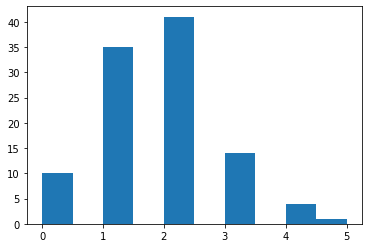

In [18]:
plt.hist(all_number_of_pollutants);